In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:

H_DIM = 20

IMAGE_DIM = (64, 64)


EPOCHS = 50
LEARNING_RATE = 0.001
BATCH_SIZE = 128


In [3]:

dataset_url = "https://github.com/deepmind/dsprites-dataset/raw/master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
dataset_path = "dsprites.npz"

if not os.path.exists(dataset_path):
    print("Downloading dsprites dataset...")
    !wget -q -O {dataset_path} {dataset_url}
    print("Download complete.")
else:
    print("Dataset already downloaded.")

class DSpritesDataset(Dataset):
    def __init__(self, npz_path):
        print("Loading dataset with memory mapping (mmap_mode)...")

        data = np.load(npz_path, mmap_mode='r')

        self.images = data['imgs']
        print(f"Dataset loaded. Total samples: {len(self.images)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image_np = self.images[idx]

        image_tensor = torch.from_numpy(image_np.astype(np.float32)).unsqueeze(0)

        return image_tensor

full_dataset = DSpritesDataset(dataset_path)
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created. Training samples: {len(train_dataset)}")



Download complete.
Loading dataset with memory mapping (mmap_mode)...
Dataset loaded. Total samples: 737280
DataLoaders created. Training samples: 663552


In [4]:

class VAE(nn.Module):
    def __init__(self, h_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(8192, h_dim)
        self.fc_logvar = nn.Linear(8192, h_dim)

        self.decoder_input = nn.Linear(h_dim, 8192)


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.decoder_input(z))
        h = h.view(-1, 128, 8, 8)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [7]:
print("\n--- بخش ۶: شروع آموزش مدل‌های β-VAE ---")

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import PCA
import warnings


def beta_loss_function(recon_x, x, mu, logvar, beta):

    BCE = F.binary_cross_entropy(recon_x.view(-1, 64*64), x.view(-1, 64*64), reduction='sum')


    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    total_loss = (BCE + beta * KLD) / x.size(0)

    avg_bce = BCE / x.size(0)
    avg_kld = KLD / x.size(0)

    return total_loss, avg_bce, avg_kld


def train_beta_model(model, optimizer, beta, num_epochs):
    print(f"\nTraining model with beta = {beta}...")

    history = {
        'total': [],
        'recon': [],
        'kl': []
    }

    for epoch in range(num_epochs):
        model.train()
        epoch_total_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0

        for batch_idx, data in enumerate(train_loader):
            data = data.to(device)

            recon_batch, mu, logvar = model(data)
            loss, recon_loss, kl_loss = beta_loss_function(recon_batch, data, mu, logvar, beta)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_total_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()

        avg_total_loss = epoch_total_loss / len(train_loader)
        avg_recon_loss = epoch_recon_loss / len(train_loader)
        avg_kl_loss = epoch_kl_loss / len(train_loader)

        history['total'].append(avg_total_loss)
        history['recon'].append(avg_recon_loss)
        history['kl'].append(avg_kl_loss)

        print(f"  Epoch [{epoch+1}/{num_epochs}], "
              f"Total: {avg_total_loss:.4f}, "
              f"Recon: {avg_recon_loss:.4f}, "
              f"KL: {avg_kl_loss:.4f} (Unweighted)")

    print(f"Training finished for beta = {beta}.")
    return model, history


--- بخش ۶: شروع آموزش مدل‌های β-VAE ---


In [8]:

def get_latents_and_factors(model, num_samples=10000):
    print(f"Extracting {num_samples} latents and factors...")

    data_npz = np.load(dataset_path)

    factors = data_npz['latents_values'][:num_samples]
    images_np = data_npz['imgs'][:num_samples]

    images = torch.from_numpy(images_np).float().unsqueeze(1).to(device)

    model.eval()
    latents = np.zeros((num_samples, H_DIM))

    with torch.no_grad():
        for i in range(0, num_samples, BATCH_SIZE):
            batch_images = images[i:i+BATCH_SIZE]
            mu, _ = model.encode(batch_images)
            latents[i:i+BATCH_SIZE] = mu.cpu().numpy()

    return latents, factors

def calculate_mutual_information(latents, factors):
    num_latents = latents.shape[1]
    num_factors = factors.shape[1]
    mi_matrix = np.zeros((num_latents, num_factors))

    warnings.filterwarnings('ignore', module='sklearn.preprocessing._discretization')
    discretizer = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
    latents_discrete = discretizer.fit_transform(latents)
    warnings.filterwarnings('default', module='sklearn.preprocessing._discretization')

    for j in range(num_latents)
        for i in range(num_factors):
            mi = mutual_info_regression(latents_discrete[:, j].reshape(-1, 1), factors[:, i])
            mi_matrix[j, i] = mi[0]

    return mi_matrix

def calculate_mig(mi_matrix):
    num_latents = mi_matrix.shape[0]
    mig_scores = []


    for j in range(num_latents):
        sorted_mi = np.sort(mi_matrix[j, :])[::-1]

        mi_k1 = sorted_mi[0]
        mi_k2 = sorted_mi[1]

        gap = mi_k1 - mi_k2

        mig_scores.append(gap)

    return np.mean(mig_scores)

In [9]:

print("\n--- بخش ۶: شروع آموزش مدل‌های β-VAE ---")
beta_1 = 1.0
model_beta_1 = VAE(h_dim=H_DIM).to(device)
optimizer_1 = optim.Adam(model_beta_1.parameters(), lr=LEARNING_RATE)
model_beta_1, history_1 = train_beta_model(model_beta_1, optimizer_1, beta=beta_1, num_epochs=EPOCHS)



--- بخش ۶: شروع آموزش مدل‌های β-VAE ---

Training model with beta = 1.0...
  Epoch [1/50], Total: 102.6608, Recon: 68.8016, KL: 33.8592 (Unweighted)
  Epoch [2/50], Total: 69.4670, Recon: 35.9591, KL: 33.5079 (Unweighted)
  Epoch [3/50], Total: 65.0205, Recon: 31.6797, KL: 33.3408 (Unweighted)
  Epoch [4/50], Total: 61.5855, Recon: 28.1605, KL: 33.4250 (Unweighted)
  Epoch [5/50], Total: 59.2320, Recon: 26.0562, KL: 33.1757 (Unweighted)
  Epoch [6/50], Total: 57.4483, Recon: 24.6427, KL: 32.8056 (Unweighted)
  Epoch [7/50], Total: 56.1332, Recon: 23.6973, KL: 32.4359 (Unweighted)
  Epoch [8/50], Total: 55.1191, Recon: 23.0162, KL: 32.1029 (Unweighted)
  Epoch [9/50], Total: 54.3052, Recon: 22.4659, KL: 31.8393 (Unweighted)
  Epoch [10/50], Total: 53.6388, Recon: 22.0172, KL: 31.6215 (Unweighted)
  Epoch [11/50], Total: 53.0859, Recon: 21.6359, KL: 31.4500 (Unweighted)
  Epoch [12/50], Total: 52.6219, Recon: 21.3402, KL: 31.2817 (Unweighted)
  Epoch [13/50], Total: 52.1750, Recon: 21.0

In [10]:

beta_2 = 4.0
model_beta_2 = VAE(h_dim=H_DIM).to(device)
optimizer_2 = optim.Adam(model_beta_2.parameters(), lr=LEARNING_RATE)
model_beta_2, history_2 = train_beta_model(model_beta_2, optimizer_2, beta=beta_2, num_epochs=EPOCHS)



Training model with beta = 4.0...
  Epoch [1/50], Total: 164.5221, Recon: 102.4102, KL: 15.5280 (Unweighted)
  Epoch [2/50], Total: 130.1542, Recon: 66.4078, KL: 15.9366 (Unweighted)
  Epoch [3/50], Total: 125.9258, Recon: 62.6609, KL: 15.8162 (Unweighted)
  Epoch [4/50], Total: 123.2477, Recon: 60.3852, KL: 15.7156 (Unweighted)
  Epoch [5/50], Total: 121.3769, Recon: 58.7457, KL: 15.6578 (Unweighted)
  Epoch [6/50], Total: 119.9545, Recon: 57.4171, KL: 15.6343 (Unweighted)
  Epoch [7/50], Total: 118.7489, Recon: 56.3119, KL: 15.6093 (Unweighted)
  Epoch [8/50], Total: 117.7462, Recon: 55.3275, KL: 15.6047 (Unweighted)
  Epoch [9/50], Total: 116.8901, Recon: 54.5090, KL: 15.5953 (Unweighted)
  Epoch [10/50], Total: 116.0876, Recon: 53.7417, KL: 15.5865 (Unweighted)
  Epoch [11/50], Total: 115.4580, Recon: 53.0619, KL: 15.5990 (Unweighted)
  Epoch [12/50], Total: 114.8753, Recon: 52.4775, KL: 15.5994 (Unweighted)
  Epoch [13/50], Total: 114.2907, Recon: 51.8836, KL: 15.6018 (Unweighted

In [11]:

beta_3 = 8.0
model_beta_3 = VAE(h_dim=H_DIM).to(device)
optimizer_3 = optim.Adam(model_beta_3.parameters(), lr=LEARNING_RATE)
model_beta_3, history_3 = train_beta_model(model_beta_3, optimizer_3, beta=beta_3, num_epochs=EPOCHS)



Training model with beta = 8.0...
  Epoch [1/50], Total: 210.0340, Recon: 128.1122, KL: 10.2402 (Unweighted)
  Epoch [2/50], Total: 179.7260, Recon: 97.6239, KL: 10.2628 (Unweighted)
  Epoch [3/50], Total: 174.5595, Recon: 92.3956, KL: 10.2705 (Unweighted)
  Epoch [4/50], Total: 171.5278, Recon: 88.8312, KL: 10.3371 (Unweighted)
  Epoch [5/50], Total: 169.3630, Recon: 86.3539, KL: 10.3761 (Unweighted)
  Epoch [6/50], Total: 167.8379, Recon: 84.7228, KL: 10.3894 (Unweighted)
  Epoch [7/50], Total: 166.5560, Recon: 83.4971, KL: 10.3824 (Unweighted)
  Epoch [8/50], Total: 165.6052, Recon: 82.4432, KL: 10.3953 (Unweighted)
  Epoch [9/50], Total: 164.7236, Recon: 81.5633, KL: 10.3950 (Unweighted)
  Epoch [10/50], Total: 163.9666, Recon: 80.7449, KL: 10.4027 (Unweighted)
  Epoch [11/50], Total: 163.3027, Recon: 80.0601, KL: 10.4053 (Unweighted)
  Epoch [12/50], Total: 162.7930, Recon: 79.5327, KL: 10.4075 (Unweighted)
  Epoch [13/50], Total: 162.1879, Recon: 78.9824, KL: 10.4007 (Unweighted


Plotting loss comparison...


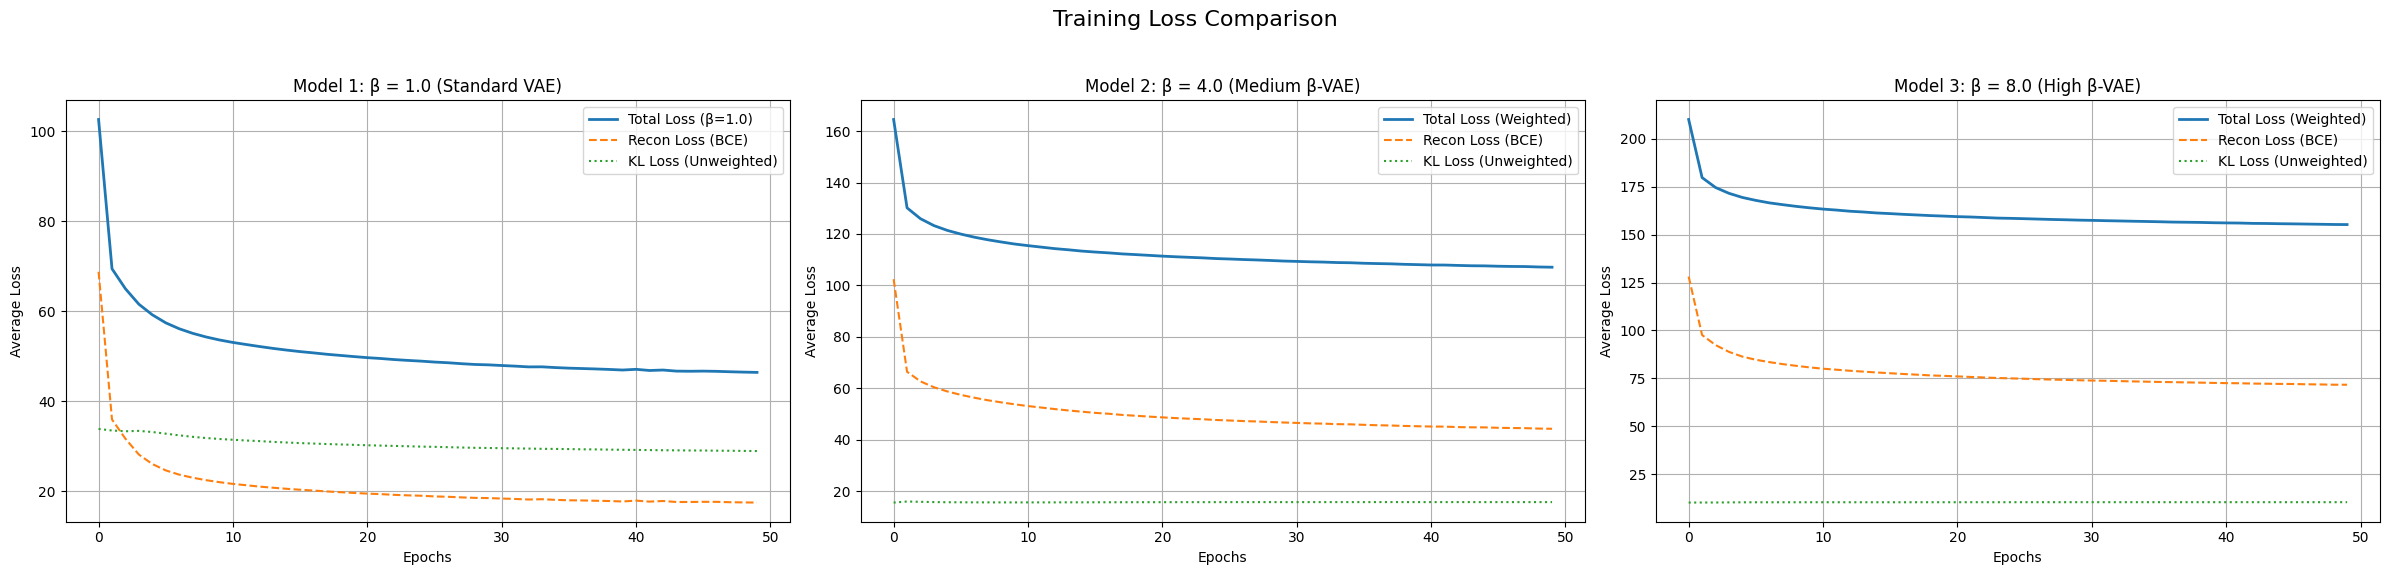

In [12]:

print("\nPlotting loss comparison...")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

ax1.plot(history_1['total'], label=f'Total Loss (β={beta_1})', linewidth=2)
ax1.plot(history_1['recon'], label='Recon Loss (BCE)', linestyle='--')
ax1.plot(history_1['kl'], label='KL Loss (Unweighted)', linestyle=':')
ax1.set_title(f'Model 1: β = {beta_1} (Standard VAE)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Average Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(history_2['total'], label=f'Total Loss (Weighted)', linewidth=2)
ax2.plot(history_2['recon'], label='Recon Loss (BCE)', linestyle='--')
ax2.plot(history_2['kl'], label='KL Loss (Unweighted)', linestyle=':')
ax2.set_title(f'Model 2: β = {beta_2} (Medium β-VAE)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Average Loss')
ax2.legend()
ax2.grid(True)

ax3.plot(history_3['total'], label=f'Total Loss (Weighted)', linewidth=2)
ax3.plot(history_3['recon'], label='Recon Loss (BCE)', linestyle='--')
ax3.plot(history_3['kl'], label='KL Loss (Unweighted)', linestyle=':')
ax3.set_title(f'Model 3: β = {beta_3} (High β-VAE)')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Average Loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Loss Comparison', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Plotting reconstruction comparison...


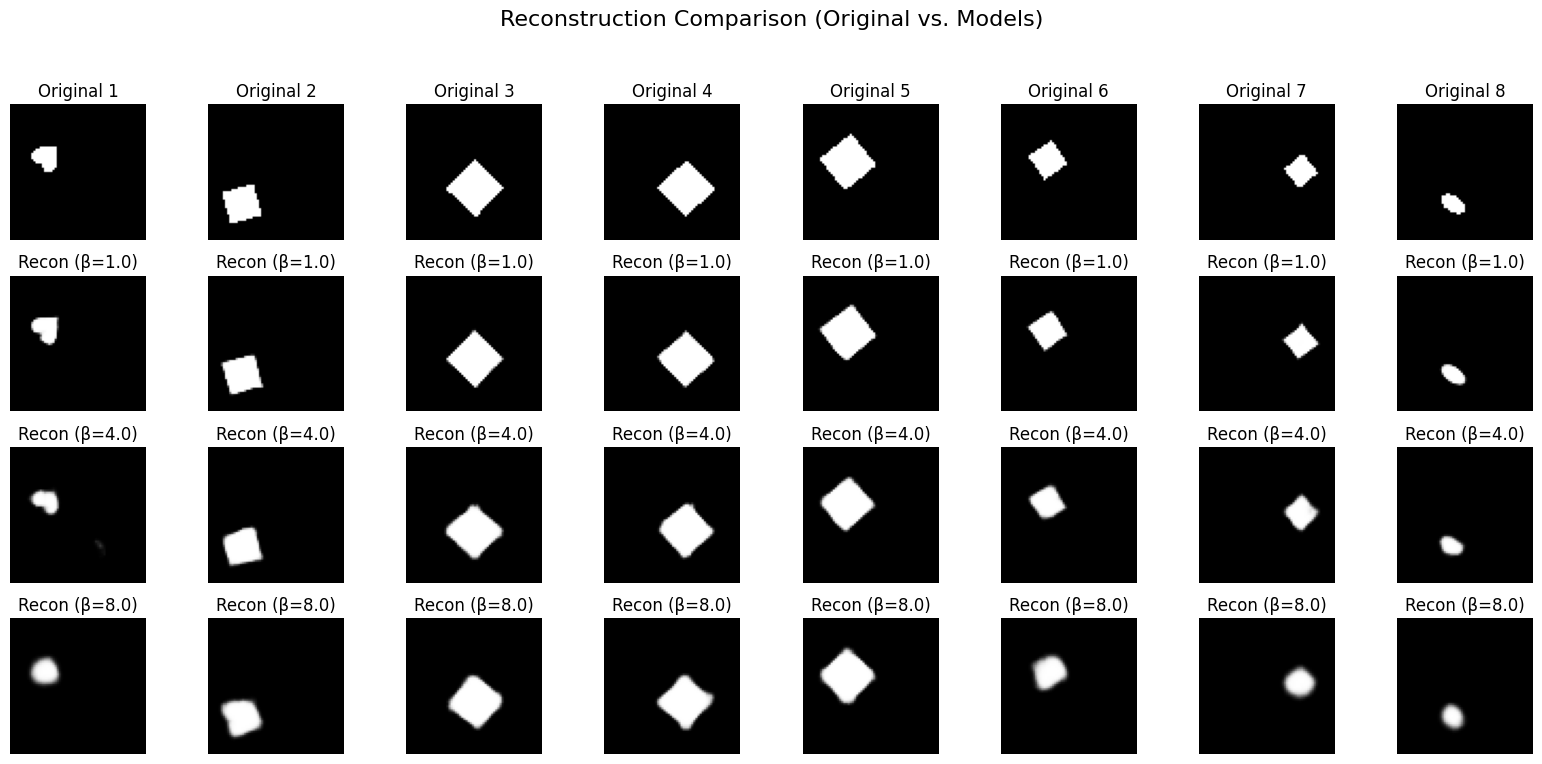

In [13]:

print("\nPlotting reconstruction comparison...")

test_images_batch = next(iter(test_loader)).to(device)
test_images = test_images_batch[:8]

model_beta_1.eval()
model_beta_2.eval()
model_beta_3.eval()
with torch.no_grad():
    recon_images_1, _, _ = model_beta_1(test_images)
    recon_images_2, _, _ = model_beta_2(test_images)
    recon_images_3, _, _ = model_beta_3(test_images)

originals = test_images.cpu().numpy().squeeze()
recons_1 = recon_images_1.cpu().numpy().squeeze()
recons_2 = recon_images_2.cpu().numpy().squeeze()
recons_3 = recon_images_3.cpu().numpy().squeeze()

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Reconstruction Comparison (Original vs. Models)', fontsize=16)

for i in range(8):
    axes[0, i].imshow(originals[i], cmap='gray')
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')

    axes[1, i].imshow(recons_1[i], cmap='gray')
    axes[1, i].set_title(f"Recon (β={beta_1})")
    axes[1, i].axis('off')

    axes[2, i].imshow(recons_2[i], cmap='gray')
    axes[2, i].set_title(f"Recon (β={beta_2})")
    axes[2, i].axis('off')

    axes[3, i].imshow(recons_3[i], cmap='gray')
    axes[3, i].set_title(f"Recon (β={beta_3})")
    axes[3, i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [14]:

print("\n--- بخش ۷: محاسبه معیار MIG ---")

latents_1, factors_1 = get_latents_and_factors(model_beta_1, num_samples=10000)
latents_2, factors_2 = get_latents_and_factors(model_beta_2, num_samples=10000)
latents_3, factors_3 = get_latents_and_factors(model_beta_3, num_samples=10000)

print("\nCalculating Mutual Information matrices...")
factor_names = ['Color', 'Shape', 'Scale', 'Rotation', 'PosX', 'PosY']
mi_matrix_1 = calculate_mutual_information(latents_1, factors_1)
mi_matrix_2 = calculate_mutual_information(latents_2, factors_2)
mi_matrix_3 = calculate_mutual_information(latents_3, factors_3)

mig_score_1 = calculate_mig(mi_matrix_1)
mig_score_2 = calculate_mig(mi_matrix_2)
mig_score_3 = calculate_mig(mi_matrix_3)

print("\n--- MIG Score Results ---")
print(f"MG Score (β = {beta_1}): {mig_score_1:.4f}")
print(f"MIG Score (β = {beta_2}): {mig_score_2:.4f}")
print(f"MIG Score (β = {beta_3}): {mig_score_3:.4f}")
print("---------------------------")


--- بخش ۷: محاسبه معیار MIG ---
Extracting 10000 latents and factors...
Extracting 10000 latents and factors...
Extracting 10000 latents and factors...

Calculating Mutual Information matrices...

--- MIG Score Results ---
MG Score (β = 1.0): 0.1642
MIG Score (β = 4.0): 0.1529
MIG Score (β = 8.0): 0.1988
---------------------------


In [15]:
def plot_pca(ax, latents, factors, model_name, factor_to_color_by='Shape'):
    print(f"Plotting PCA for {model_name}...")

    pca = PCA(n_components=2)
    latents_2d = pca.fit_transform(latents)


    factor_map = {name: i for i, name in enumerate(factor_names)}
    factor_idx = factor_map.get(factor_to_color_by, 1)

    factor_values = factors[:, factor_idx]

    scatter = ax.scatter(latents_2d[:, 0], latents_2d[:, 1],
                         c=factor_values, cmap='viridis',
                         s=2, alpha=0.5)

    legend = ax.legend(*scatter.legend_elements(), title=factor_to_color_by)
    ax.add_artist(legend)

    ax.set_title(f"PCA of Latent Space ({model_name})\nColored by {factor_to_color_by}")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.grid(True)


--- بخش ۸: تحلیل PCA ---
Plotting PCA for β = 1.0...
Plotting PCA for β = 4.0...
Plotting PCA for β = 8.0...


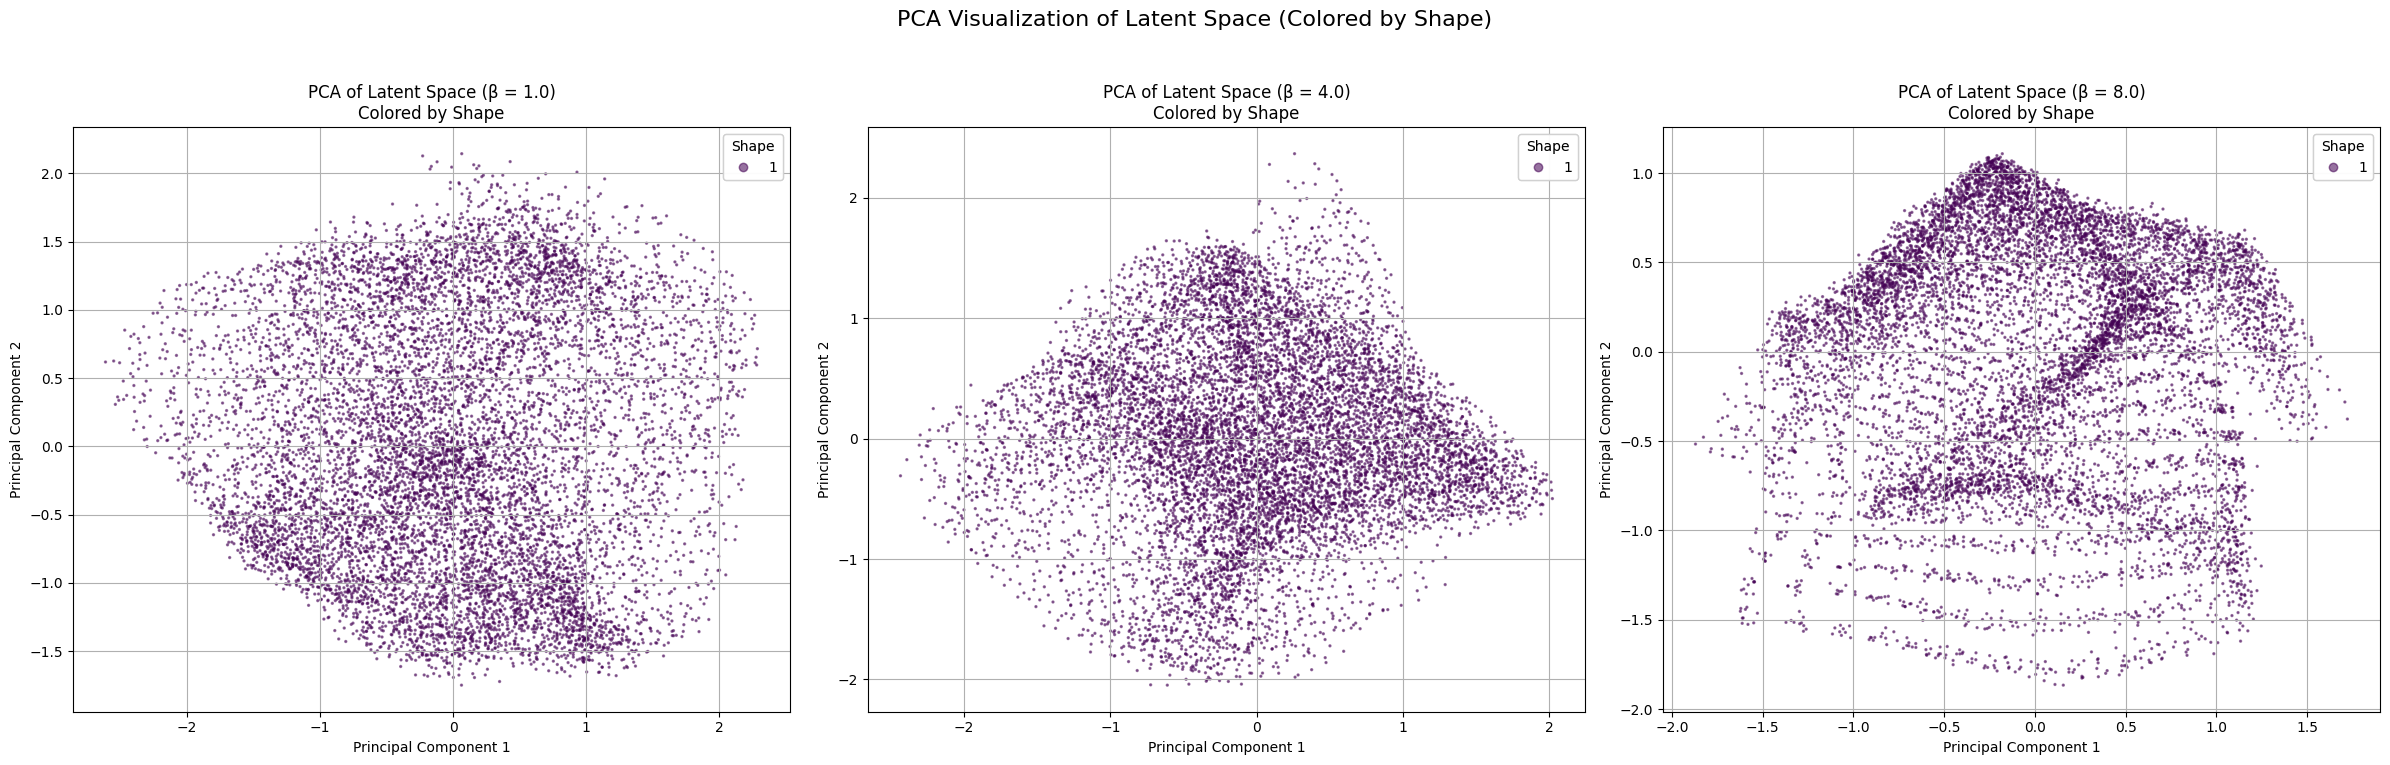

In [17]:

print("\n--- بخش ۸: تحلیل PCA ---")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

plot_pca(ax1, latents_1, factors_1, model_name=f"β = {beta_1}", factor_to_color_by='Shape')

plot_pca(ax2, latents_2, factors_2, model_name=f"β = {beta_2}", factor_to_color_by='Shape')

plot_pca(ax3, latents_3, factors_3, model_name=f"β = {beta_3}", factor_to_color_by='Shape')

plt.suptitle("PCA Visualization of Latent Space (Colored by Shape)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
